In [ ]:
! pip install rdkit

For canonical smiles

In [ ]:
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
import pandas as pd

# Load only the first 400,000 rows
df = pd.read_csv("/content/NP_TRAIN_COCONUT.csv", nrows=100000)
smiles_col = [col for col in df.columns if "smile" in col.lower()][0]

# Define standardizers
uncharger = rdMolStandardize.Uncharger()
tautomer_enumerator = rdMolStandardize.TautomerEnumerator()
fragment_remover = rdMolStandardize.FragmentRemover()

def standardize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    try:
        # Remove fragments/salts
        mol = fragment_remover.remove(mol)

        # Filter by heavy atom count
        if mol.GetNumHeavyAtoms() > 80:
            return None

        # Sanitize molecule
        Chem.SanitizeMol(mol)

        # Normalize molecule
        mol = rdMolStandardize.Normalize(mol)

        # Uncharge molecule
        mol = uncharger.uncharge(mol)

        # Tautomer canonicalization
        mol = tautomer_enumerator.Canonicalize(mol)

        # Return canonical SMILES without stereochemistry
        return Chem.MolToSmiles(mol, canonical=True, isomericSmiles=False)

    except Exception:
        return None

# Apply standardization
df["Clean_SMILES"] = df[smiles_col].apply(standardize_smiles)

# Drop invalid and duplicate SMILES
df = df[df["Clean_SMILES"].notnull()].drop_duplicates(subset=["Clean_SMILES"])

# Save cleaned output
df.to_csv("Cleaned_Standardized_Zinc.csv", index=False)
print("Cleaned SMILES saved:", df.shape)


Streaming output truncated to the last 5000 lines.
[13:11:10] Running Uncharger
[13:11:10] Running FragmentRemover
[13:11:10] Initializing Normalizer
[13:11:10] Running Normalizer
[13:11:10] Running Uncharger
[13:11:10] Running FragmentRemover
[13:11:10] Initializing Normalizer
[13:11:10] Running Normalizer
[13:11:10] Running Uncharger
[13:11:10] Running FragmentRemover
[13:11:10] Initializing Normalizer
[13:11:10] Running Normalizer
[13:11:10] Running Uncharger
[13:11:10] Running FragmentRemover
[13:11:10] Initializing Normalizer
[13:11:10] Running Normalizer
[13:11:10] Running Uncharger
[13:11:10] Running FragmentRemover
[13:11:10] Initializing Normalizer
[13:11:10] Running Normalizer
[13:11:10] Running Uncharger
[13:11:10] Removed negative charge.
[13:11:10] Running FragmentRemover
[13:11:10] Initializing Normalizer
[13:11:10] Running Normalizer
[13:11:10] Running Uncharger
[13:11:10] Running FragmentRemover
[13:11:10] Initializing Normalizer
[13:11:10] Running Normalizer
[13:11:10]

In [ ]:
df.head()

For calculating natural MACCS fp

In [ ]:
import os
import pandas as pd
from padelpy import padeldescriptor
from concurrent.futures import ThreadPoolExecutor
import glob

# === CONFIGURATION ===
input_csv = '/home/sanjana24225/synthetic/Synthetic_Canonical_160k.csv'
bitwise_fp_path = '/home/sanjana24225/Fingerprints'
output_folder = 'Output'
fp_name = 'MACCS'
batch_size = 10000
max_workers = 3
threads_per_job = 2

os.makedirs(output_folder, exist_ok=True)

# === STEP 1: Load Input CSV ===
df = pd.read_csv(input_csv)

if 'Clean_SMILES' in df.columns:
    smiles_column = 'Clean_SMILES'
elif 'Canonical' in df.columns:
    smiles_column = 'Canonical'
else:
    smiles_column = 'smiles'

df = df[pd.notnull(df[smiles_column])].copy()
df['MolID'] = ['Mol' + str(i) for i in range(len(df))]

# === STEP 2: Split SMILES to Batches ===
def write_batch_smi(batch_df, batch_idx):
    smi_path = f'{output_folder}/batch_{batch_idx}.smi'
    with open(smi_path, 'w') as f:
        for _, row in batch_df.iterrows():
            f.write(f"{row[smiles_column]} {row['MolID']}\n")
    return smi_path

batch_files = []
for i in range(0, len(df), batch_size):
    batch_df = df.iloc[i:i+batch_size]
    smi_file = write_batch_smi(batch_df, i)
    batch_files.append((smi_file, i))

# === STEP 3: Run PaDEL in Parallel ===
fp_xml = os.path.join(bitwise_fp_path, f'{fp_name}Fingerprinter.xml')

def run_padel(smi_file, batch_idx):
    out_csv = os.path.join(output_folder, f'{fp_name}_batch_{batch_idx}.csv')
    print(f" Running PaDEL on batch starting at {batch_idx}")
    padeldescriptor(
        mol_dir=smi_file,
        d_file=out_csv,
        descriptortypes=fp_xml,
        detectaromaticity=True,
        standardizenitro=True,
        standardizetautomers=True,
        threads=threads_per_job,
        removesalt=True,
        fingerprints=True
    )
    return out_csv

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    executor.map(lambda args: run_padel(*args), batch_files)

# === STEP 4: Merge All Fingerprint Outputs ===
fps = pd.concat((pd.read_csv(f) for f in glob.glob(f'{output_folder}/{fp_name}_batch_*.csv')), ignore_index=True)
# === STEP 5: Merge with Original Data ===
merged = df.merge(fps, left_on='MolID', right_on='Name', how='inner')
cleaned = merged[merged['MolID'] == merged['Name']].copy()
cleaned.drop(columns=['Name'], inplace=True)

# === STEP 6: Save Final Cleaned File ===
final_output = f'{fp_name}_fingerprints_cleaned.csv'
cleaned.to_csv(final_output, index=False)
print(f" Final file saved as {final_output}")


Concatenate both dataset

In [ ]:
import pandas as pd

# Load cleaned fingerprint CSVs
df_syn = pd.read_csv("KlekotaRoth_fingerprints_cleaned_syn.csv")
df_nat = pd.read_csv("KlekotaRoth_fingerprints_cleaned_natural.csv")

# Add class labels
df_syn['Label'] = 0  # Synthetic
df_nat['Label'] = 1  # Natural

# Detect fingerprint columns
fp_cols = [col for col in df_syn.columns if col.startswith("KRFP")]

# Ensure 'Clean_SMILES', fingerprint columns, and 'Label' are selected
columns_to_keep = ['Clean_SMILES'] + fp_cols + ['Label']
df_syn = df_syn[columns_to_keep]
df_nat = df_nat[columns_to_keep]

# Merge both datasets
df_merged = pd.concat([df_syn, df_nat], ignore_index=True)

# Save to new CSV
df_merged.to_csv("merged_klekotaroth_fingerprints_labeled.csv", index=False)


In [ ]:
df_merged.head(10000)

,Clean_SMILES,KRFP1,KRFP2,KRFP3,KRFP4,KRFP5,KRFP6,KRFP7,KRFP8,KRFP9,...,KRFP4852,KRFP4853,KRFP4854,KRFP4855,KRFP4856,KRFP4857,KRFP4858,KRFP4859,KRFP4860,Label
0,Cc1ncc(COP(=O)(O)O)c(C=O)c1O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,NC(Cc1c[nH]cn1)C(=O)O,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,CC(=O)C(=O)O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,NC(Cc1ccccc1)C(=O)O,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,O=C(O)CCCCC1SCC2NC(=O)NC21,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,CS(=O)(=O)NCC1OCC(N(Cc2ccc(C(=O)O)cc2)Cc2ccc(C...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9996,CCCC=CCC(OC(C=CC(CC=CCCCC(=O)O)OCC1OC(OCC(O)CO...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9997,CC1(C(=O)CO)C=C2CCC3C(C)(C)CCCC3(C)C2CC1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9998,CCC(C)CCCCCCCCCCCCCCCCCCCCC(=O)OCC(COC(=O)CCCC...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
import pandas as pd

# Load your merged dataset
df = pd.read_csv("merged_klekotaroth_fingerprints_labeled.csv")

# Identify fingerprint columns
fp_columns = [col for col in df.columns if col.startswith("KRFP")]

# Count the number of 1s per row
fp_ones_per_row = df[fp_columns].sum(axis=1)

# Count how many rows have at least one 1
num_with_at_least_one_fp = (fp_ones_per_row > 0).sum()
total_molecules = len(df)

print(f"Molecules with at least one fingerprint bit = 1: {num_with_at_least_one_fp}")
print(f"Total molecules: {total_molecules}")
print(f"Percentage with fingerprint hits: {num_with_at_least_one_fp / total_molecules * 100:.2f}%")


Molecules with at least one fingerprint bit = 1: 19258
Total molecules: 19275
Percentage with fingerprint hits: 99.91%


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      1855
           1       0.95      0.93      0.94      2000

    accuracy                           0.94      3855
   macro avg       0.94      0.94      0.94      3855
weighted avg       0.94      0.94      0.94      3855

ROC AUC Score: 0.984440026954178


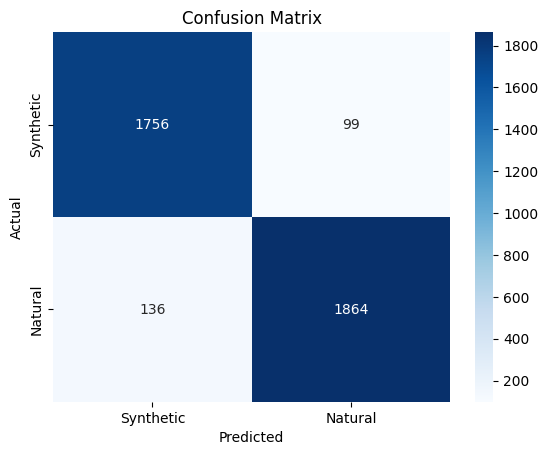

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load your merged dataset
df = pd.read_csv("merged_klekotaroth_fingerprints_labeled.csv")

# Extract features (X) and target (y)
fp_cols = [col for col in df.columns if col.startswith("KRFP")]
X = df[fp_cols]
y = df["Label"]

# Split into train/test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Print metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Synthetic", "Natural"], yticklabels=["Synthetic", "Natural"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import numpy as np

# Load your dataset
df = pd.read_csv("merged_klekotaroth_fingerprints_labeled.csv")

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split features and labels
X = df.drop(columns=['Clean_SMILES', 'Label'])
y = df['Label']

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Initialize model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 5-fold CV on training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')

# Train and evaluate on test set
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_test)[:, 1]
test_auroc = roc_auc_score(y_test, y_proba)

# Print results
print("Cross-validation AUROC scores:", cv_scores)
print("Mean CV AUROC:", np.mean(cv_scores))
print("Test Set AUROC:", test_auroc)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:45:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:45:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:45:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:46:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:46:18] WARNING: /w

Cross-validation AUROC scores: [0.98677392 0.98219761 0.98348067 0.98809952 0.98715044]
Mean CV AUROC: 0.9855404312668463
Test Set AUROC: 0.98538948787062


In [ ]:
df.head(10000)

,Clean_SMILES,KRFP1,KRFP2,KRFP3,KRFP4,KRFP5,KRFP6,KRFP7,KRFP8,KRFP9,...,KRFP4852,KRFP4853,KRFP4854,KRFP4855,KRFP4856,KRFP4857,KRFP4858,KRFP4859,KRFP4860,Label
0,CN=C(NC)NCCC(=O)OCc1ccccc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,COc1ccc(CN2CC3CC(C2)c2ccc(C4CCCCC4)c(=O)n2C3)cc1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,CC(C)NCC1COCc2nc3cc(F)ccc3n21,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,COC(=NCCCl)N(CCCl)N=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,CC1CC=CCC=CCC(=O)Cc2cc(O)cc(O)c2C(=O)O1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,O=C1C(=Cc2ccc(O)c(O)c2)Oc2cc(OC3OC(CO)C(O)C(O)...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9996,COc1ccc(OC)c(C(O)CN(C)C(=O)CN)c1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9997,CC(=O)OC1C=C2C3CC(C)(C)CCC3(C)CCC2(C)C2(C)CCC3...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9998,NCC1=NC(=O)CNN1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


With 5 types of Fp as features

In [ ]:
import pandas as pd
from functools import reduce

# === Step 1: File paths for natural and synthetic sets ===
files = {
    'PubChem': ('PubChem_fingerprints_cleaned_natural_10k.csv', 'PubChem_fingerprints_cleaned_syn_10k.csv'),
    'Extended': ('ExtendedFingerprinter_fingerprints_cleaned_natural_10k.csv', 'ExtendedFingerprinter_fingerprints_cleaned_syn_10k.csv'),
    'MACCS': ('MACCSFingerprinter_fingerprints_cleaned_natural_10k.csv', 'MACCSFingerprinter_fingerprints_cleaned_syn_10k.csv'),
    'AtomPairs2D': ('AtomPairs2DFingerprintCount_fingerprints_cleaned_natural_10k.csv', 'AtomPairs2DFingerprintCount_fingerprints_cleaned_syn_10k.csv'),
    'KlekotaRoth': ('KlekotaRoth_fingerprints_cleaned_natural_10k.csv', 'KlekotaRoth_fingerprints_cleaned_syn_10k.csv')
}

# === LOAD FUNCTION (keeps original column names, filters out unwanted columns) ===
def load_fps(path, label):
    df = pd.read_csv(path)
    df['Label'] = label

    # Columns to keep always
    keep_cols = ['MolID', 'Clean_SMILES', 'Label']

    # Only keep bit-vector columns (drop SMILES, Fingerprint strings, etc.)
    fp_cols = [
        col for col in df.columns
        if col not in keep_cols and not any(x in col.lower() for x in ['smiles', 'fingerprint'])
    ]

    return df[keep_cols + fp_cols]

# === STEP 2: Load all fingerprint files for natural and synthetic ===
dfs_natural = []
dfs_synthetic = []

for _, (natural_path, synthetic_path) in files.items():
    dfs_natural.append(load_fps(natural_path, label=0))
    dfs_synthetic.append(load_fps(synthetic_path, label=1))

# === STEP 3: Merge fingerprint groups on ['MolID', 'Clean_SMILES', 'Label'] ===
def safe_merge(dfs):
    if len(dfs) == 1:
        return dfs[0]
    return reduce(
        lambda left, right: pd.merge(left, right, on=['MolID', 'Clean_SMILES', 'Label'], how='inner'),
        dfs
    )

natural_merged = safe_merge(dfs_natural)
synthetic_merged = safe_merge(dfs_synthetic)

# === STEP 4: Combine Natural + Synthetic data
final_df = pd.concat([natural_merged, synthetic_merged], ignore_index=True)

# === STEP 5: Save to CSV
final_df.to_csv("Combined_AllFingerprints_OriginalNames.csv", index=False)
print(" Final dataset saved as Combined_AllFingerprints_OriginalNames.csv")



MergeError: Passing 'suffixes' which cause duplicate columns {'SAS_x', 'qed_x', 'logP_x'} is not allowed.

In [ ]:
final_df.head(10000)

,MolID,Clean_SMILES,Label,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,...,KRFP4851,KRFP4852,KRFP4853,KRFP4854,KRFP4855,KRFP4856,KRFP4857,KRFP4858,KRFP4859,KRFP4860
0,Mol0,Cc1cc(OC2OC(CO)C(O)C(O)C2O)c2c3c(c(=O)oc2c1)CCC3,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Mol1,COC(=O)CC(c1ccccc1)c1c(O)cc(O)c2c(=O)cc(-c3ccc...,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Mol2,C=C1CC(OC)(C(O)C(=O)NC2OCOC3C2OC(CC(CO)OC)C(C)...,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mol3,C=C1C2CCC3(O)C4(C)CCCC(C)(C(=O)O)C4CCC3(C2)C1O...,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Mol4,COc1ccc(CCNC(=O)C(C)N(c2ccccc2)S(C)(=O)=O)cc1,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Mol9995,Cc1ccc(S(=O)(=O)N2CC(F)C(OCc3nc4ccccc4o3)C2)cc1,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,Mol9996,CCOC(=O)C(C)Oc1cc(C)cc2oc(=O)c3c(c12)CCCC3,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,Mol9997,O=C(CCO)N1CC2CC(O)CN2C2(C1)CN(C(=O)Cc1ccccc1)C2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,Mol9998,O=C(COc1ccc2c3c(c(=O)oc2c1)CCC3)c1ccc(F)cc1,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import pandas as pd

# Load the merged CSV file
df = pd.read_csv("Combined_AllFingerprints_OriginalNames.csv")

# Get number of columns
num_columns = df.shape[1]

print(f" Number of columns: {num_columns}")


🧬 Number of columns: 7714


Number of subgroups

In [ ]:
import pandas as pd

# Define the file paths
files = {
    'PubChem': 'PubChem_fingerprints_cleaned_natural_10k.csv',
    'Extended': 'ExtendedFingerprinter_fingerprints_cleaned_natural_10k.csv',
    'MACCS': 'MACCSFingerprinter_fingerprints_cleaned_natural_10k.csv',
    'AtomPairs2D': 'AtomPairs2DFingerprintCount_fingerprints_cleaned_natural_10k.csv',
    'KlekotaRoth': 'KlekotaRoth_fingerprints_cleaned_natural_10k.csv'
}

# Loop through each fingerprint group
for name, file in files.items():
    df = pd.read_csv(file)

    # Count columns excluding the first 5
    feature_columns = df.columns[5:]
    num_features = len(feature_columns)

    print(f"{name} Fingerprint has {num_features} feature columns.")


PubChem Fingerprint has 880 feature columns.
Extended Fingerprint has 1023 feature columns.
MACCS Fingerprint has 165 feature columns.
AtomPairs2D Fingerprint has 779 feature columns.
KlekotaRoth Fingerprint has 4859 feature columns.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from xgboost import XGBClassifier
from sklearn.utils import shuffle

# STEP 1: Load the merged fingerprint dataset
df = pd.read_csv("Combined_AllFingerprints_OriginalNames.csv")

# STEP 2: Shuffle the dataset
df = shuffle(df, random_state=42)

# STEP 3: Prepare features and labels
# Assuming: 0 - MolID, 1 - Clean_SMILES, 2 - Label, 3 onward - Fingerprints
X = df.iloc[:, 3:]        # All fingerprint features (after skipping first 3 columns)
y = df['Label']           # Classification label

# STEP 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# STEP 5: Initialize and train model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# STEP 6: Evaluate on test set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\n Test Set Accuracy:", accuracy_score(y_test, y_pred))
print(" Test Set AUROC:", roc_auc_score(y_test, y_prob))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

# STEP 7: 5-Fold Cross-Validation on full data (AUROC)
cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print("\n 5-Fold Cross-Validation AUROC Scores:", cv_scores)
print(" Mean AUROC (CV):", cv_scores.mean())


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:27:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Test Set Accuracy: 0.951491569390402
✅ Test Set AUROC: 0.9904198113207546

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      2000
           1       0.95      0.95      0.95      1855

    accuracy                           0.95      3855
   macro avg       0.95      0.95      0.95      3855
weighted avg       0.95      0.95      0.95      3855



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:28:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:29:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:30:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:31:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:32:07] WARNING: /w


📈 5-Fold Cross-Validation AUROC Scores: [0.98818383 0.99219488 0.98759313 0.98937844 0.98846685]
📉 Mean AUROC (CV): 0.989163423180593


 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2000
           1       0.92      0.95      0.94      1855

    accuracy                           0.94      3855
   macro avg       0.94      0.94      0.94      3855
weighted avg       0.94      0.94      0.94      3855


 Top 30 Most Important Features:
APC2D1_C_C      0.015431
APC2D2_C_O      0.014845
APC2D6_C_C      0.010849
APC2D10_C_C     0.010354
APC2D9_C_C      0.010214
APC2D9_C_O      0.010002
APC2D7_C_O      0.009568
APC2D7_C_C      0.009560
APC2D4_C_N      0.009402
APC2D2_C_N      0.008388
APC2D6_C_O      0.008251
APC2D3_C_C      0.007939
APC2D8_C_C      0.007889
APC2D10_C_O     0.006889
MACCSFP140      0.006593
ExtFP93         0.006593
APC2D2_C_C      0.006340
PubchemFP701    0.006072
PubchemFP285    0.006039
APC2D4_C_C      0.006031
APC2D1_C_O      0.006012
APC2D5_C_C      0.005544
APC2D5_C_O      0.005387
PubchemFP341    0.005331
KRFP3712       

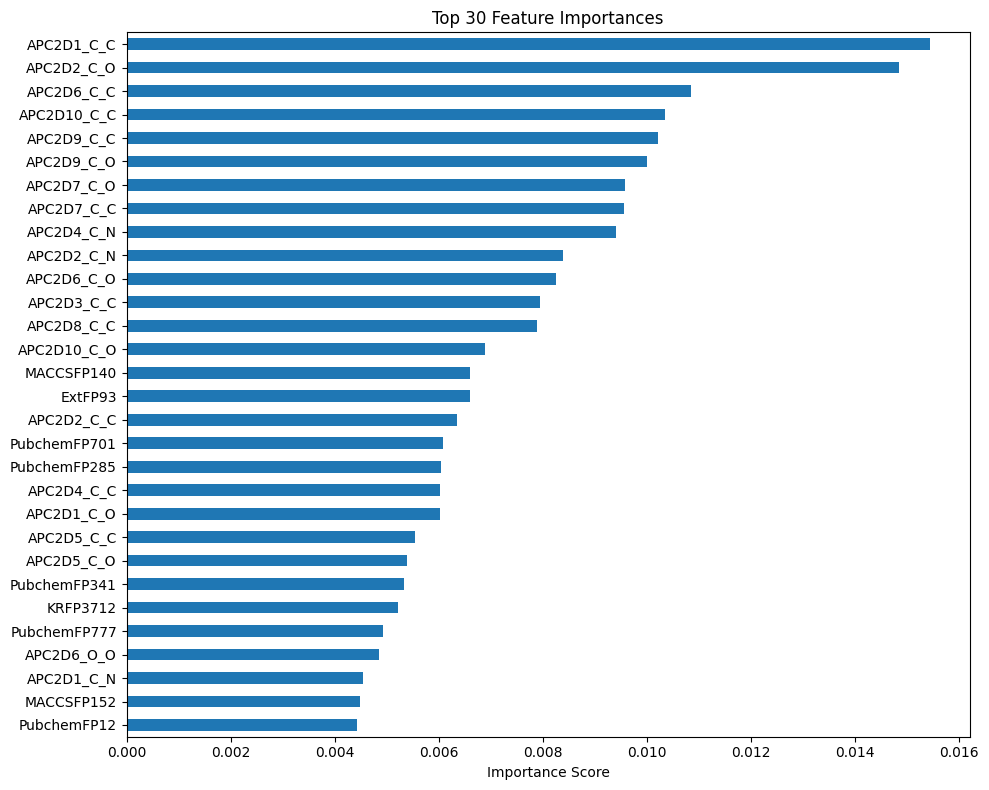

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# === STEP 1: Load Final Combined Dataset ===
df = pd.read_csv("/content/Combined_AllFingerprints_OriginalNames.csv")

# === STEP 2: Prepare Features & Labels ===
X = df.drop(columns=["MolID", "Clean_SMILES", "Label"])
y = df["Label"]

# === STEP 3: Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# === STEP 4: Fit Random Forest Model ===
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# === STEP 5: Evaluate the Model ===
y_pred = rf.predict(X_test)
print(" Classification Report:")
print(classification_report(y_test, y_pred))

# === STEP 6: Extract Feature Importances ===
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)

# === STEP 7: Top 30 Important Features ===
top_n = 30
print(f"\n Top {top_n} Most Important Features:")
print(importances_sorted.head(top_n))

# === STEP 8: Plot Feature Importances ===
plt.figure(figsize=(10, 8))
importances_sorted.head(top_n).plot(kind='barh')
plt.title(f"Top {top_n} Feature Importances")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
!pip install rdkit-pypi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 25.4 MB/s eta 0:00:00


In [ ]:
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors

fp, bitInfo = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024, bitInfo={})



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found

NameError: name 'mol' is not defined

________________________________________________________________________________________________________________________________________________


Zinc vs natural

In [ ]:
import pandas as pd

# List of ZINC fingerprint CSVs
zinc_files = [
    "PubChem_fingerprints_cleaned_zinc.csv",
    "ExtendedFingerprinter_fingerprints_cleaned_zinc.csv",
    "MACCSFingerprinter_fingerprints_cleaned_zinc.csv",
    "AtomPairs2DFingerprintCount_fingerprints_cleaned_zinc.csv",
    "KlekotaRothFingerprinter_fingerprints_cleaned_zinc.csv"
]

# Columns/keywords to remove
drop_patterns = ["logp", "sas", "qed"]

for file in zinc_files:
    df = pd.read_csv(file)

    # Identify columns to drop (case-insensitive)
    cols_to_drop = [col for col in df.columns if any(pat in col.lower() for pat in drop_patterns)]

    # Drop them
    df_clean = df.drop(columns=cols_to_drop)

    # Optional: save cleaned file (overwrite or new file)
    cleaned_file = file.replace(".csv", "_no_desc.csv")
    df_clean.to_csv(cleaned_file, index=False)

    print(f"✅ Cleaned {file} -> {cleaned_file}, dropped columns: {cols_to_drop}")


✅ Cleaned PubChem_fingerprints_cleaned_zinc.csv -> PubChem_fingerprints_cleaned_zinc_no_desc.csv, dropped columns: ['logP', 'qed', 'SAS']
✅ Cleaned ExtendedFingerprinter_fingerprints_cleaned_zinc.csv -> ExtendedFingerprinter_fingerprints_cleaned_zinc_no_desc.csv, dropped columns: ['logP', 'qed', 'SAS']
✅ Cleaned MACCSFingerprinter_fingerprints_cleaned_zinc.csv -> MACCSFingerprinter_fingerprints_cleaned_zinc_no_desc.csv, dropped columns: ['logP', 'qed', 'SAS']
✅ Cleaned AtomPairs2DFingerprintCount_fingerprints_cleaned_zinc.csv -> AtomPairs2DFingerprintCount_fingerprints_cleaned_zinc_no_desc.csv, dropped columns: ['logP', 'qed', 'SAS']
✅ Cleaned KlekotaRothFingerprinter_fingerprints_cleaned_zinc.csv -> KlekotaRothFingerprinter_fingerprints_cleaned_zinc_no_desc.csv, dropped columns: ['logP', 'qed', 'SAS']


In [ ]:
import pandas as pd
from functools import reduce

# === Step 1: File paths for natural and cleaned ZINC sets ===
files = {
    'PubChem': (
        'PubChem_fingerprints_cleaned_natural_10k.csv',
        'PubChem_fingerprints_cleaned_zinc_no_desc.csv'
    ),
    'Extended': (
        'ExtendedFingerprinter_fingerprints_cleaned_natural_10k.csv',
        'ExtendedFingerprinter_fingerprints_cleaned_zinc_no_desc.csv'
    ),
    'MACCS': (
        'MACCSFingerprinter_fingerprints_cleaned_natural_10k.csv',
        'MACCSFingerprinter_fingerprints_cleaned_zinc_no_desc.csv'
    ),
    'AtomPairs2D': (
        'AtomPairs2DFingerprintCount_fingerprints_cleaned_natural_10k.csv',
        'AtomPairs2DFingerprintCount_fingerprints_cleaned_zinc_no_desc.csv'
    ),
    'KlekotaRoth': (
        'KlekotaRoth_fingerprints_cleaned_natural_10k.csv',
        'KlekotaRothFingerprinter_fingerprints_cleaned_zinc_no_desc.csv'
    )
}

# === Step 2: Function to load fingerprints ===
def load_fps(path, label):
    df = pd.read_csv(path)
    df['Label'] = label
    keep_cols = ['MolID', 'Clean_SMILES', 'Label']
    fp_cols = [c for c in df.columns if c not in keep_cols and df[c].dtype in ['int64', 'float64', 'bool']]
    return df[keep_cols + fp_cols]

# === Step 3: Load all fingerprint groups ===
dfs_natural = []
dfs_zinc = []

for _, (natural_path, zinc_path) in files.items():
    dfs_natural.append(load_fps(natural_path, label=0))
    dfs_zinc.append(load_fps(zinc_path, label=1))

# === Step 4: Merge fingerprint types on ['MolID', 'Clean_SMILES', 'Label'] ===
def safe_merge(dfs):
    if len(dfs) == 1:
        return dfs[0]
    return reduce(
        lambda left, right: pd.merge(left, right, on=['MolID', 'Clean_SMILES', 'Label'], how='inner'),
        dfs
    )

natural_merged = safe_merge(dfs_natural)
zinc_merged = safe_merge(dfs_zinc)

# === Step 5: Assign new unique MolID across natural + ZINC ===
# First natural
natural_merged = natural_merged.reset_index(drop=True)
natural_merged['MolID'] = ['Mol' + str(i) for i in range(len(natural_merged))]

# Then ZINC, continuing numbering
zinc_merged = zinc_merged.reset_index(drop=True)
start_idx = len(natural_merged)
zinc_merged['MolID'] = ['Mol' + str(i) for i in range(start_idx, start_idx + len(zinc_merged))]

# === Step 6: Combine datasets ===
final_df = pd.concat([natural_merged, zinc_merged], ignore_index=True)

# === Step 7: Save final cleaned dataset ===
output_file = "Combined_AllFingerprints_UniqueMolID.csv"
final_df.to_csv(output_file, index=False)

print(f"✅ Final dataset saved: {output_file}")
print(f"Shape: {final_df.shape}")
print(f"Natural count: {len(natural_merged)}, ZINC count: {len(zinc_merged)}")


✅ Final dataset saved: Combined_AllFingerprints_UniqueMolID.csv
Shape: (20000, 7714)
Natural count: 10000, ZINC count: 10000


In [ ]:
final_df.head(20001)

,MolID,Clean_SMILES,Label,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,...,KRFP4851,KRFP4852,KRFP4853,KRFP4854,KRFP4855,KRFP4856,KRFP4857,KRFP4858,KRFP4859,KRFP4860
0,Mol0,Cc1cc(OC2OC(CO)C(O)C(O)C2O)c2c3c(c(=O)oc2c1)CCC3,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Mol1,COC(=O)CC(c1ccccc1)c1c(O)cc(O)c2c(=O)cc(-c3ccc...,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Mol2,C=C1CC(OC)(C(O)C(=O)NC2OCOC3C2OC(CC(CO)OC)C(C)...,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mol3,C=C1C2CCC3(O)C4(C)CCCC(C)(C(=O)O)C4CCC3(C2)C1O...,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Mol4,COc1ccc(CCNC(=O)C(C)N(c2ccccc2)S(C)(=O)=O)cc1,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,Mol19995,CC(c1ccc(F)cc1)N(C)C(=O)CC1C=CCC1,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,Mol19996,CC1(C)CC(=O)C(C)(CCc2ccccc2)C(=O)C1,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,Mol19997,COc1cc(C#N)ccc1OC(=O)c1c(C)noc1C,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19998,Mol19998,CC(C)c1cc(C(=O)Nc2ccc(CN3CCCC3)cc2)[nH]n1,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Print all column names
print("All columns in final dataset:")
print(final_df.columns.tolist())


All columns in final dataset:
['MolID', 'Clean_SMILES', 'Label', 'PubchemFP0', 'PubchemFP1', 'PubchemFP2', 'PubchemFP3', 'PubchemFP4', 'PubchemFP5', 'PubchemFP6', 'PubchemFP7', 'PubchemFP8', 'PubchemFP9', 'PubchemFP10', 'PubchemFP11', 'PubchemFP12', 'PubchemFP13', 'PubchemFP14', 'PubchemFP15', 'PubchemFP16', 'PubchemFP17', 'PubchemFP18', 'PubchemFP19', 'PubchemFP20', 'PubchemFP21', 'PubchemFP22', 'PubchemFP23', 'PubchemFP24', 'PubchemFP25', 'PubchemFP26', 'PubchemFP27', 'PubchemFP28', 'PubchemFP29', 'PubchemFP30', 'PubchemFP31', 'PubchemFP32', 'PubchemFP33', 'PubchemFP34', 'PubchemFP35', 'PubchemFP36', 'PubchemFP37', 'PubchemFP38', 'PubchemFP39', 'PubchemFP40', 'PubchemFP41', 'PubchemFP42', 'PubchemFP43', 'PubchemFP44', 'PubchemFP45', 'PubchemFP46', 'PubchemFP47', 'PubchemFP48', 'PubchemFP49', 'PubchemFP50', 'PubchemFP51', 'PubchemFP52', 'PubchemFP53', 'PubchemFP54', 'PubchemFP55', 'PubchemFP56', 'PubchemFP57', 'PubchemFP58', 'PubchemFP59', 'PubchemFP60', 'PubchemFP61', 'PubchemFP62', 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from xgboost import XGBClassifier
from sklearn.utils import shuffle

# =================== STEP 1: Load dataset ===================
df = pd.read_csv("Combined_AllFingerprints_UniqueMolID.csv")
print(f"Dataset shape: {df.shape}")

# =================== STEP 2: Shuffle dataset ===================
df = shuffle(df, random_state=42)

# =================== STEP 3: Prepare features & labels ===================
# Features: all fingerprint columns (from 4th column onwards)
# =================== STEP 3: Prepare features & labels ===================
# Features: all fingerprint columns (from 4th column onwards)
X = df.iloc[:, 3:]  # MolID, Clean_SMILES, Label are first 3 columns, so slice starts at PubchemFP0
y = df['Label']     # label column

print(f"Feature shape: {X.shape}, Labels shape: {y.shape}")

# =================== STEP 4: Train-test split ===================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# =================== STEP 5: Train XGBoost model ===================
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1
)
model.fit(X_train, y_train)

# =================== STEP 6: Evaluate on test set ===================
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\n✅ Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("✅ Test Set AUROC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# =================== STEP 7: 5-Fold Cross-Validation ===================
cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print("\n5-Fold Cross-Validation AUROC Scores:", cv_scores)
print("Mean AUROC (CV):", cv_scores.mean())


Dataset shape: (20000, 7714)
Feature shape: (20000, 7711), Labels shape: (20000,)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:03:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Test Set Accuracy: 0.9295
✅ Test Set AUROC: 0.98155375

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93      2000
           1       0.92      0.95      0.93      2000

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:04:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:06:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:07:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:08:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:10:06] WARNING: /w


5-Fold Cross-Validation AUROC Scores: [0.98194975 0.9840285  0.98078175 0.984039   0.98205025]
Mean AUROC (CV): 0.98256985


In [ ]:
df.head(20000)

,MolID,Clean_SMILES,Label,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,...,KRFP4851,KRFP4852,KRFP4853,KRFP4854,KRFP4855,KRFP4856,KRFP4857,KRFP4858,KRFP4859,KRFP4860
10650,Mol10650,CC(C(=O)N1CCCC1)N1CCN(C(=O)NCc2ccco2)CC1,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2041,Mol2041,CC(=O)OC1C(O)C(C)OC(OC2C(OC(=O)C3CCC4C(C3)OC3(...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8668,Mol8668,COc1ccc(O)c(C(=O)NCCc2ccc(OC)c(OC)c2)c1,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1114,Mol1114,COc1cc(CCC(O)C2C(=O)CC(c3cc(O)c(O)c(OCC4C=CCC(...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13902,Mol13902,O=C(C1CCOc2ccccc21)N1CCCCCC1c1ccco1,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,Mol11284,COc1cccc(CNC(=O)c2ccc([N+](=O)[O-])cc2F)c1,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11964,Mol11964,COc1ccc(OCC(=O)N2CC(OCc3ccc(Cl)cc3)C2)cc1,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5390,Mol5390,Cc1nc(S(=O)(=O)N2CC(COc3cnccn3)C3COc4ccc(F)cc4...,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,Mol860,CCc1cccc(CC2C(OC(=O)C=Cc3ccc(O)c(O)c3)C(O)(OC(...,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Top 20 Important Features:
           Feature  Importance
285   PubchemFP285    0.117224
2151    APC2D2_C_O    0.033609
351   PubchemFP351    0.027795
2228    APC2D3_C_N    0.020188
639   PubchemFP639    0.018685
2227    APC2D3_C_C    0.016506
613   PubchemFP613    0.007662
6732      KRFP3882    0.007481
1979     MACCSFP75    0.006364
7087      KRFP4237    0.006058
2069    MACCSFP165    0.005489
617   PubchemFP617    0.005132
20     PubchemFP20    0.004856
1896     ExtFP1016    0.004755
2306    APC2D4_C_N    0.004525
2021    MACCSFP117    0.004434
6549      KRFP3699    0.004406
2043    MACCSFP139    0.004290
353   PubchemFP353    0.004208
1108      ExtFP228    0.003995


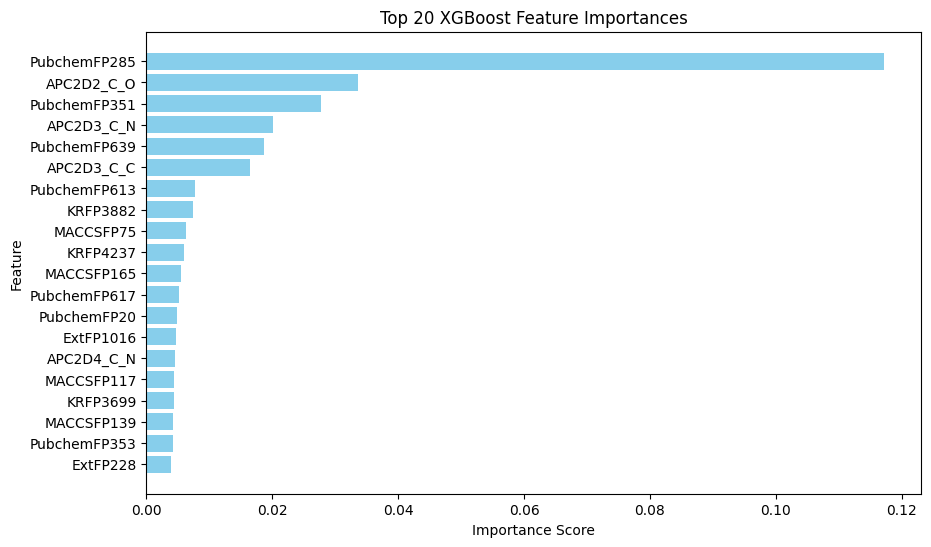

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# STEP 8: Feature Importance (Numeric)
feature_importances = model.feature_importances_

# Match them with column names
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 20 Important Features:")
print(feature_importance_df.head(20))

# STEP 9: Plot Feature Importance (Top 20)
top_n = 20
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:top_n],
         feature_importance_df['Importance'][:top_n],
         color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title(f'Top {top_n} XGBoost Feature Importances')
plt.gca().invert_yaxis()  # Most important at the top
plt.show()
